In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from copy import deepcopy as dp
import seaborn as sns

import warnings

In [2]:
from backtest import *
from basic_strategy import Strategy

In [5]:
def calc_portfolio_value(portfolio, state, new_cash):
    value = -new_cash  # subtract new cash added
    for ticker, info in portfolio.items():
        if ticker == 'cash':
            continue
        ticker_price = state[ticker]['adj_close']
        ticker_portfolio_amount = info['volume']
        value += ticker_price * ticker_portfolio_amount
    return value

In [44]:
def plot_results(df):
    num_plots = 4
    
    plt.figure(figsize=(16, 10))
    
    plt.subplot(num_plots, 1, 1)
    plt.plot(df['portfolio_values'], label='portfolio values')
    plt.ylabel('USD')
    plt.grid()
    plt.legend()
    
    plt.subplot(num_plots, 1, 2)
    plt.plot(df['returns'], label='returns')
    plt.ylabel('%')
    plt.grid()
    plt.legend()
    
    plt.subplot(num_plots, 1, 3)
    plt.plot(df['returns'] / df['returns'].shift(1) * 100, label='cumulative returns')
    plt.ylabel('%')
    plt.grid()
    plt.legend()
    
    plt.subplot(num_plots, 1, 4)
    sns.histplot(df['returns'], kde=False, bins=60, label='returns distribution',
                 line_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
    plt.ylabel('%')
    plt.grid()
    plt.legend()
    
    plt.show()

In [45]:
res['returns'] += 1

In [46]:
res['returns'] *= 100

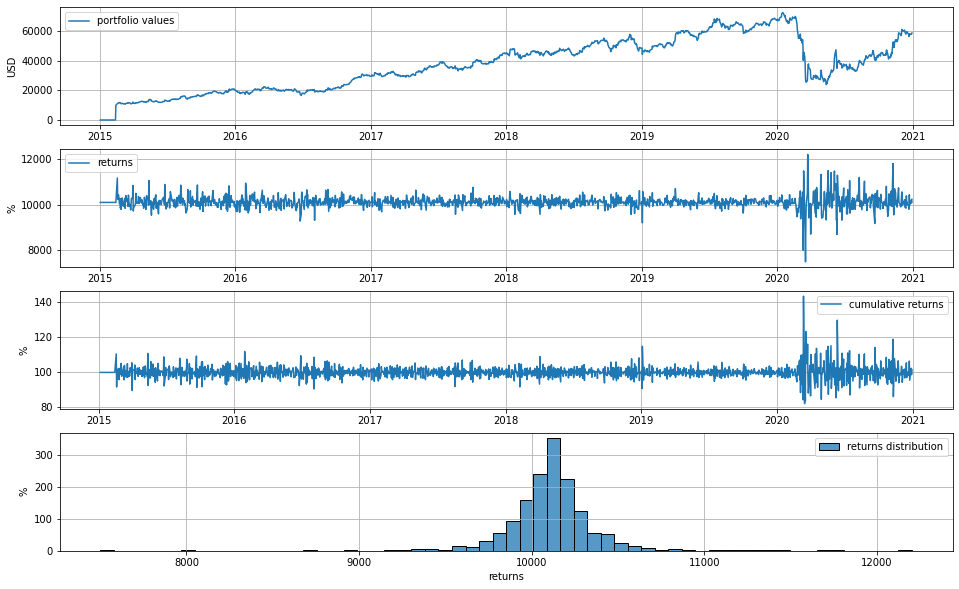

In [47]:
plot_results(res)

In [7]:
def run_backtest(path_to_data, tickers, strategy, strategy_params, 
                 start_date, end_date, commission, selected_cols,
                 viz=True, logging=True):
    
    data = warmup(tickers, path_to_data, start_date, end_date, selected_cols, logging)
    
    strategy.portfolio_init(**strategy_params)
    
    portfolio_values = []
    times = []
    
    for index, (time, state) in enumerate(data.items()):
        des, new_money = strategy.get_decision(index, time, state)  # основываясь на текущем портфеле и новой информации, стратегия принимает решение
        cash_left = 0
        for side, tickers in des.items():
            for ticker, money in tickers.items():
                price = state[ticker]['adj_close']
                amount = money // price  # FIXME: check if it's correct for sell
                cashback = money % price
                strategy.portfolio_update(ticker, price, amount, side)
                cash_left += cashback
                if logging:
                    print('Added:', index, time, ticker, price, amount, side)
        strategy.portfolio_update('cash', 1, cash_left, True)
        curr_value = calc_portfolio_value(strategy.portfolio, state, new_money)
        portfolio_values.append(curr_value)
        times.append(time)
        
    res_data = np.array([portfolio_values, times]).T
    res_df = pd.DataFrame(res_data, columns=['portfolio_values', 'times'])
    res_df['portfolio_values'] = res_df['portfolio_values'].astype(float)
    res_df['times'] = pd.to_datetime(res_df['times'])
    res_df = res_df.set_index('times')
    res_df['returns'] = res_df['portfolio_values'].pct_change().replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(value=0)
    
    if viz:
        plot_results(res_df)
        
    return res_df, strategy

In [33]:
path_to_data = 'data'
tickers = ['AMD', 'INTC']
tickers = ['DAL']
start_date = '2015-01-01'
end_date = '2021-01-01'

selected_cols = ['EPS (Basic)']

commission = 0.001

In [34]:
strategy_params = {}
strategy_params['start_money'] = 10000
strategy_params['regular_money'] = 1000
strategy_params['money_freq'] = 30
strategy_params['decision_freq'] = 30

In [35]:
strategy = Strategy()

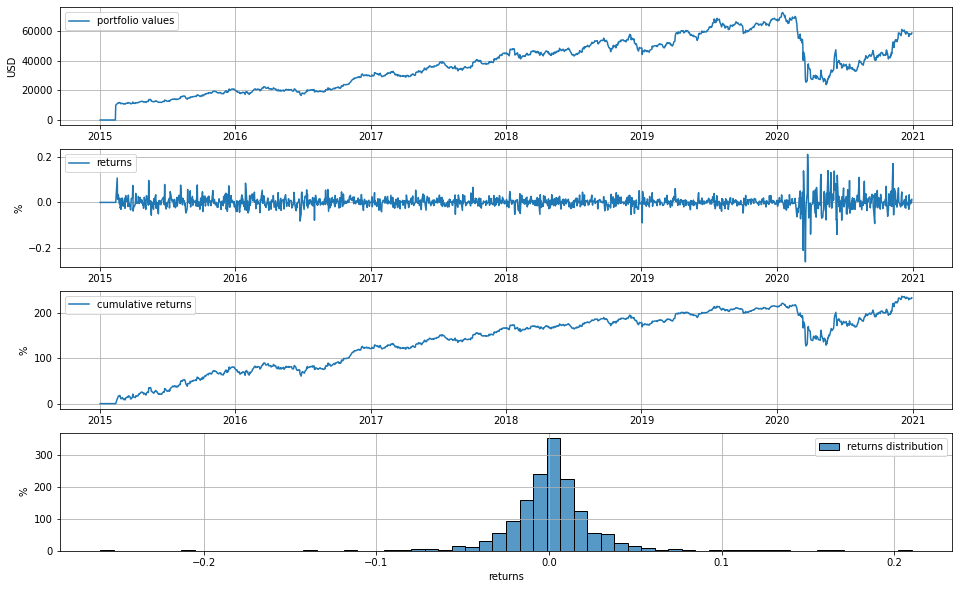

In [36]:
res, done_strategy = run_backtest(path_to_data, tickers, strategy, strategy_params, 
                   start_date, end_date, commission, selected_cols, logging=False)

In [28]:
done_strategy.portfolio

{'cash': 82.99942016601562,
 'XOM': {'price': 67.97385163065992, 'volume': 771.0}}

# to do

Бэктест:
- выбор типа цены - close / adj close
- учет комиссии
- учет дивидендов
- добавление цены в финальный датасет
- корректный расчет доходностей
- сравнение с бенчмарком  

Данные:
- купить подписку
- адаптировать формат под текущий бэктест

Стратегия:
- переписать стратегию на питон

In [12]:
done_strategy.portfolio

{'cash': 135.1682586669922,
 'AMD': {'price': 5.1070440142023905, 'volume': 5159.0},
 'INTC': {'price': 33.8599562770442, 'volume': 760.0}}